# Differential expression - Breast cancer

In [12]:
import scanpy as sc
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

from tqdm import tqdm_notebook

In [13]:
sc.set_figure_params(dpi=100)

## Read the data

In [14]:
adata = sc.read('results/hdst-breast-cancer-lowres-5x-smooth-0.5sigma.h5ad')
adata

AnnData object with n_obs × n_vars = 29950 × 23058 
    obs: 'x', 'y', 'Fatty tissue', 'Fatty tissue;Fibrous tissue;Invasive cancer', 'Fatty tissue;Fibrous tissue;Invasive cancer;immune/lymphoid', 'Fatty tissue;Invasive cancer', 'Fatty tissue;Invasive cancer;immune/lymphoid', 'Fatty tissue;immune/lymphoid', 'Fibrous tissue', 'Fibrous tissue;Invasive cancer', 'Fibrous tissue;Invasive cancer;immune/lymphoid', 'Fibrous tissue;immune/lymphoid', 'Invasive cancer', 'Invasive cancer;immune/lymphoid', 'Unknown', 'immune/lymphoid', 'missing', 'total_counts', 'region'
    var: 'gene_symbols', 'gene_ids'
    obsm: 'X_spatial'
    layers: 'smooth_overall'

In [15]:
ad = adata.copy()
ad._inplace_subset_obs(ad.X.sum(1) > 0.0)
print(ad.X.sum(1).mean(), ad.X.sum(1).std())

ad = adata.copy()
ad.X = ad.layers['smooth_overall']
ad._inplace_subset_obs(ad.X.sum(1) > 0.0)
print(ad.X.sum(1).mean(), ad.X.sum(1).std())

25.483017 17.617126
38.03072 23.587532


... storing 'region' as categorical


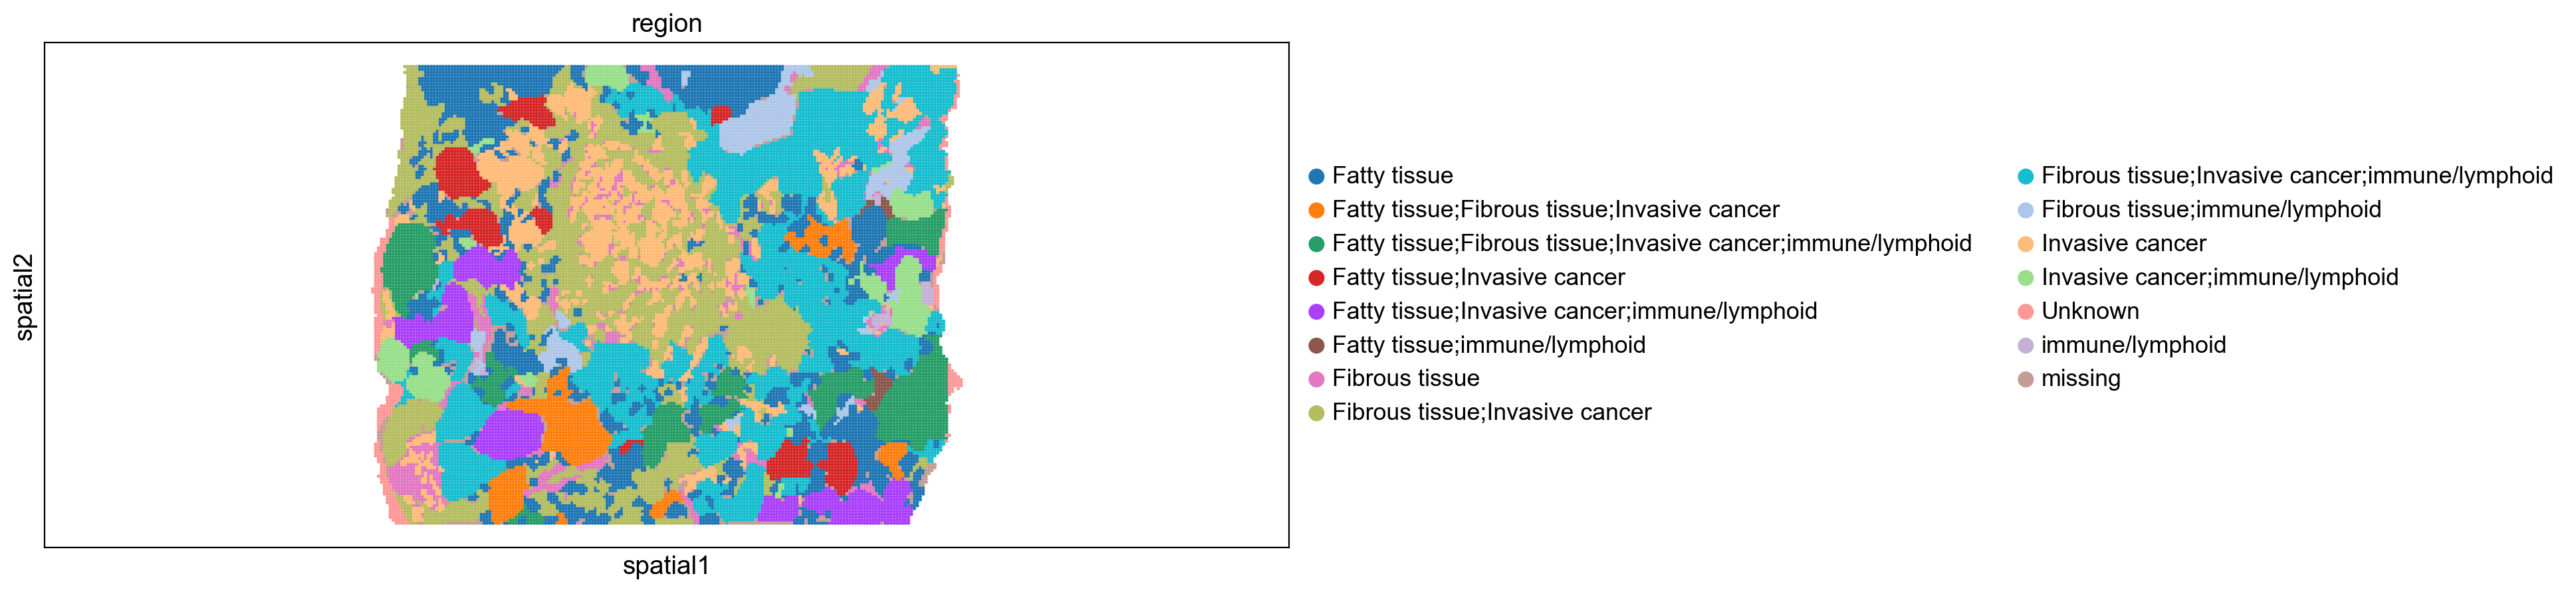

In [4]:
f, ax = plt.subplots(figsize=(12,5))
ax.axis('equal')
sc.pl.scatter(adata, basis='spatial', color='region', size=15, ax=ax, show=False)

Text(0.5, 1.0, 'Total count distributions per-bin')

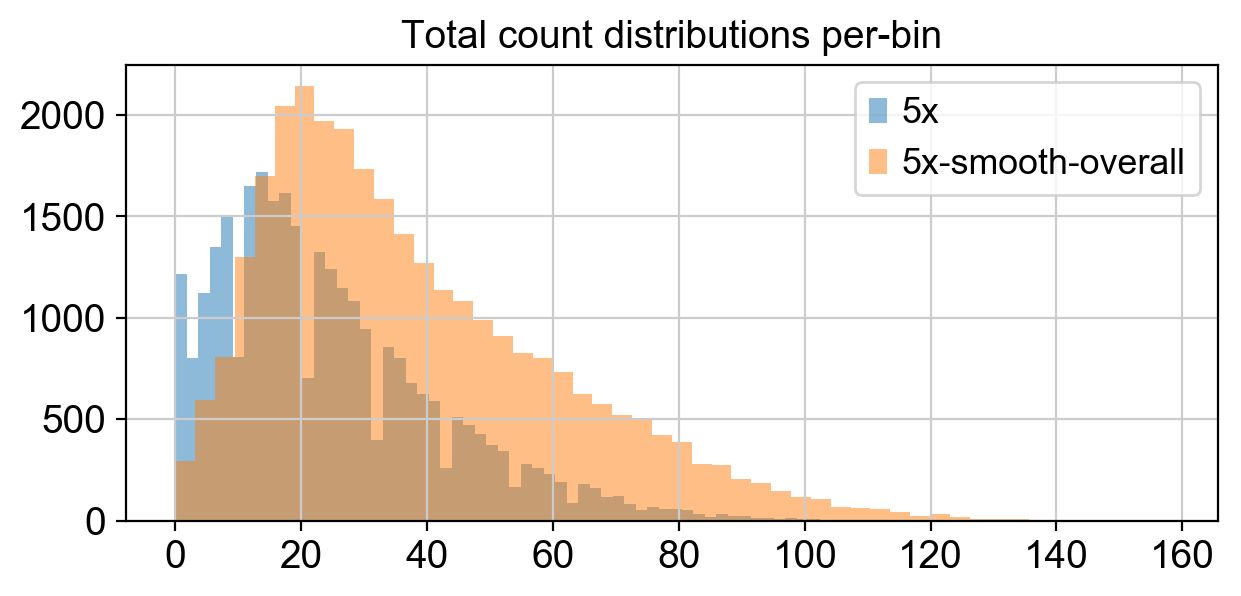

In [6]:
plt.figure(figsize=(7,3))
plt.hist(adata.X.sum(1), bins=70, alpha=0.5);
plt.hist(adata.layers['smooth_overall'].sum(1), bins=50, alpha=0.5);
plt.legend(['5x', '5x-smooth-overall'])
plt.title('Total count distributions per-bin')

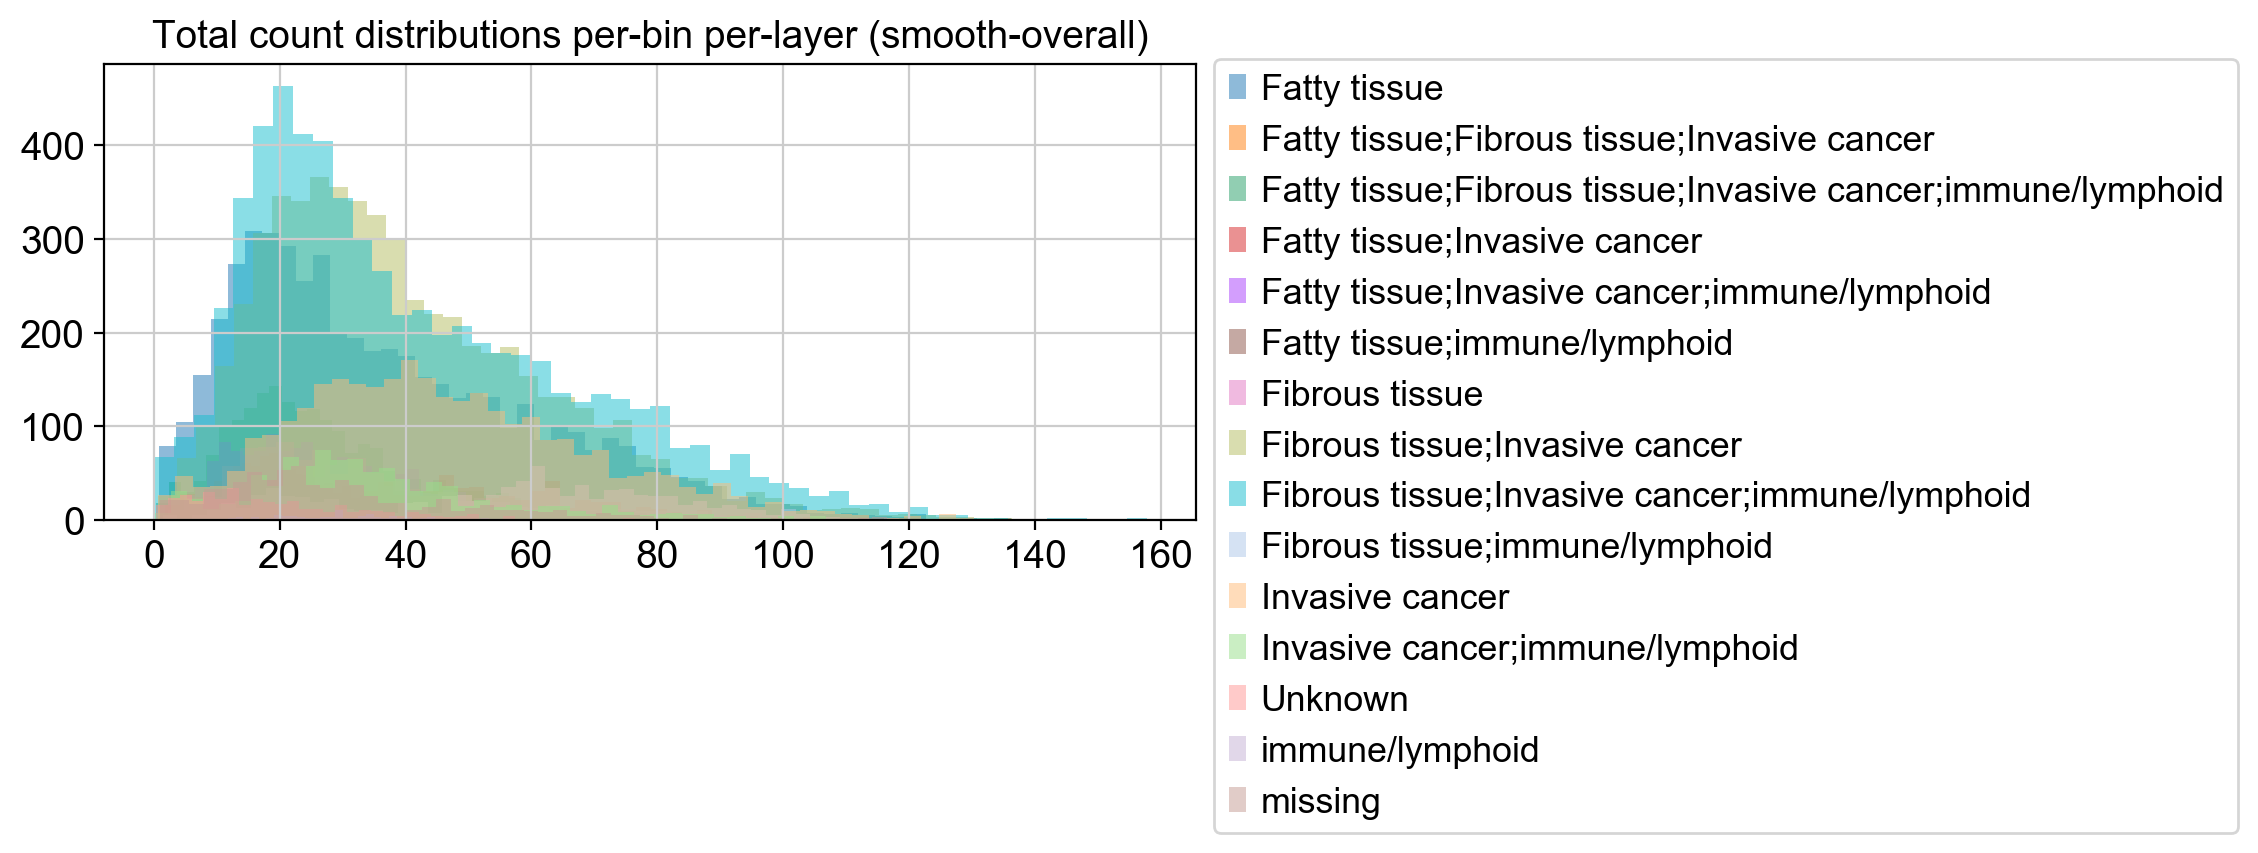

In [7]:
plt.figure(figsize=(7,3))

for c in adata.obs.region.cat.categories:
    plt.hist(adata[adata.obs.region == c].layers['smooth_overall'].sum(1), bins=50, alpha=0.5, label=c);
    plt.title('Total count distributions per-bin per-layer (smooth-overall)')
    plt.legend(loc=0,bbox_to_anchor=(1, 1.05))

# Differential Expression

## Visualization

In [16]:
from statsmodels.stats.multitest import multipletests

def visualize_de(adata, cat_name, 
                 binarize=False,
                 pval_cutoff=0.1,
                 lfc=1.5,
                 std_expression=True, 
                 layer=None, 
                 figsize=(25,6),
                 figname_mean=None,
                 figname_pval=None):

    ## top genes
    de = tidy_up_scanpy_de_all(adata, cat_name)    
    de = de[(de.pvalsadj <= pval_cutoff) & (de.log2foldchanges > lfc)]
    top_genes = list(set(de.names))
    print('%s DE genes' % len(top_genes))
    assert len(top_genes) < 2000, 'Too many DE genes...'
    
    pvals_adj = tidy_up_scanpy_de(adata, cat_name)    
    pvals_adj_long = pvals_adj
    pvals_adj_long[cat_name] = pvals_adj_long.index
    pvals_adj_long = pvals_adj_long.melt(cat_name, var_name='gene', value_name='pvaladj').sort_values('pvaladj')
    pvals_adj_long = pvals_adj_long[pvals_adj_long.gene.isin(top_genes)].reset_index()

    if layer is None:
        x = adata[:, top_genes].X.toarray()
    else:
        x = adata[:, top_genes].layers[layer]

    if binarize:
        xdf = pd.DataFrame((x > 0).astype(np.float32), columns=top_genes)
    else:
        xdf = pd.DataFrame(x, columns=top_genes)
    
    xdf_mean = xdf.groupby(adata.obs[cat_name].values).mean()
    cm = sns.clustermap(xdf_mean, standard_scale=1 if std_expression else None, cmap='viridis', figsize=figsize);

    if figname_mean is not None:
        cm.savefig(figname_mean)

    ## P values
    ridx = cm.dendrogram_row.reordered_ind
    cidx = cm.dendrogram_col.reordered_ind

    pval_mat = pvals_adj.loc[:, top_genes]
    pval_mat[pval_mat == 0.0] = 1e-300
    pval_mat = -np.log10(pval_mat)
    pval_mat[pval_mat<np.log10(pval_cutoff)] = 0
    pval_mat = pval_mat.rename_axis(None, axis=0).rename_axis(None, axis=1)

    cm = sns.clustermap(pval_mat.iloc[ridx, cidx], cmap='Reds', figsize=figsize, col_cluster=False, row_cluster=False)

    if figname_pval is not None:
        cm.savefig(figname_pval)
    
def tidy_up_scanpy_de_all(ad, groupby):

    dfs = []

    for c in ad.obs[groupby].cat.categories:
        names = pd.DataFrame(ad.uns['rank_genes_groups']['names'][c], columns=['names'])
        
        scores = pd.DataFrame(ad.uns['rank_genes_groups']['scores'][c], columns=['tstat'])
        lfc = pd.DataFrame(ad.uns['rank_genes_groups']['logfoldchanges'][c], columns=['log2foldchanges'])
        pvals = pd.DataFrame(ad.uns['rank_genes_groups']['pvals'][c], columns=['pvals'])

        pvalsadj = pd.DataFrame(ad.uns['rank_genes_groups']['pvals_adj'][c], columns=['pvalsadj'])
        pvalsadj.values[pvalsadj.values > 1.] = 1. # workaround for scanpy bug

        df = pd.concat([names, scores, lfc, pvals, pvalsadj], axis=1)
        df['group'] = c
        dfs.append(df)

    df = pd.concat(dfs, axis=0)
    df['group'] = df['group'].astype('category')
    df = df.rename_axis(None, axis=0).rename_axis(None, axis=1)
    
    return df

    
def tidy_up_scanpy_de(ad, groupby):

    dfs = []

    for c in ad.obs[groupby].cat.categories:
        names = pd.DataFrame(ad.uns['rank_genes_groups']['names'][c], columns=['names'])
        pvalsadj = pd.DataFrame(ad.uns['rank_genes_groups']['pvals_adj'][c], columns=['pvalsadj'])
        pvalsadj.values[pvalsadj.values > 1.] = 1. # workaround for scanpy bug
        df = pd.concat([names, pvalsadj], axis=1)
        df['group'] = c
        dfs.append(df)

    df = pd.concat(dfs, axis=0)
    df['group'] = df['group'].astype('category')
    df = df.rename_axis(None, axis=0).rename_axis(None, axis=1)
    
    return df.pivot_table('pvalsadj', index='names', columns='group').T

## DE

In [17]:
%%time

adata_smooth_overall = adata.copy()
adata_smooth_overall._inplace_subset_obs(~adata_smooth_overall.obs.region.isin(['missing', 'Unknown']))
adata_smooth_overall._inplace_subset_var(adata_smooth_overall.X.sum(0) > 0.0)
sc.pp.log1p(adata_smooth_overall)
sc.tl.rank_genes_groups(adata_smooth_overall, 'region', n_genes=adata_smooth_overall.n_vars)

... storing 'region' as categorical


CPU times: user 3min 48s, sys: 1min 7s, total: 4min 56s
Wall time: 5min 6s


... storing 'region' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.


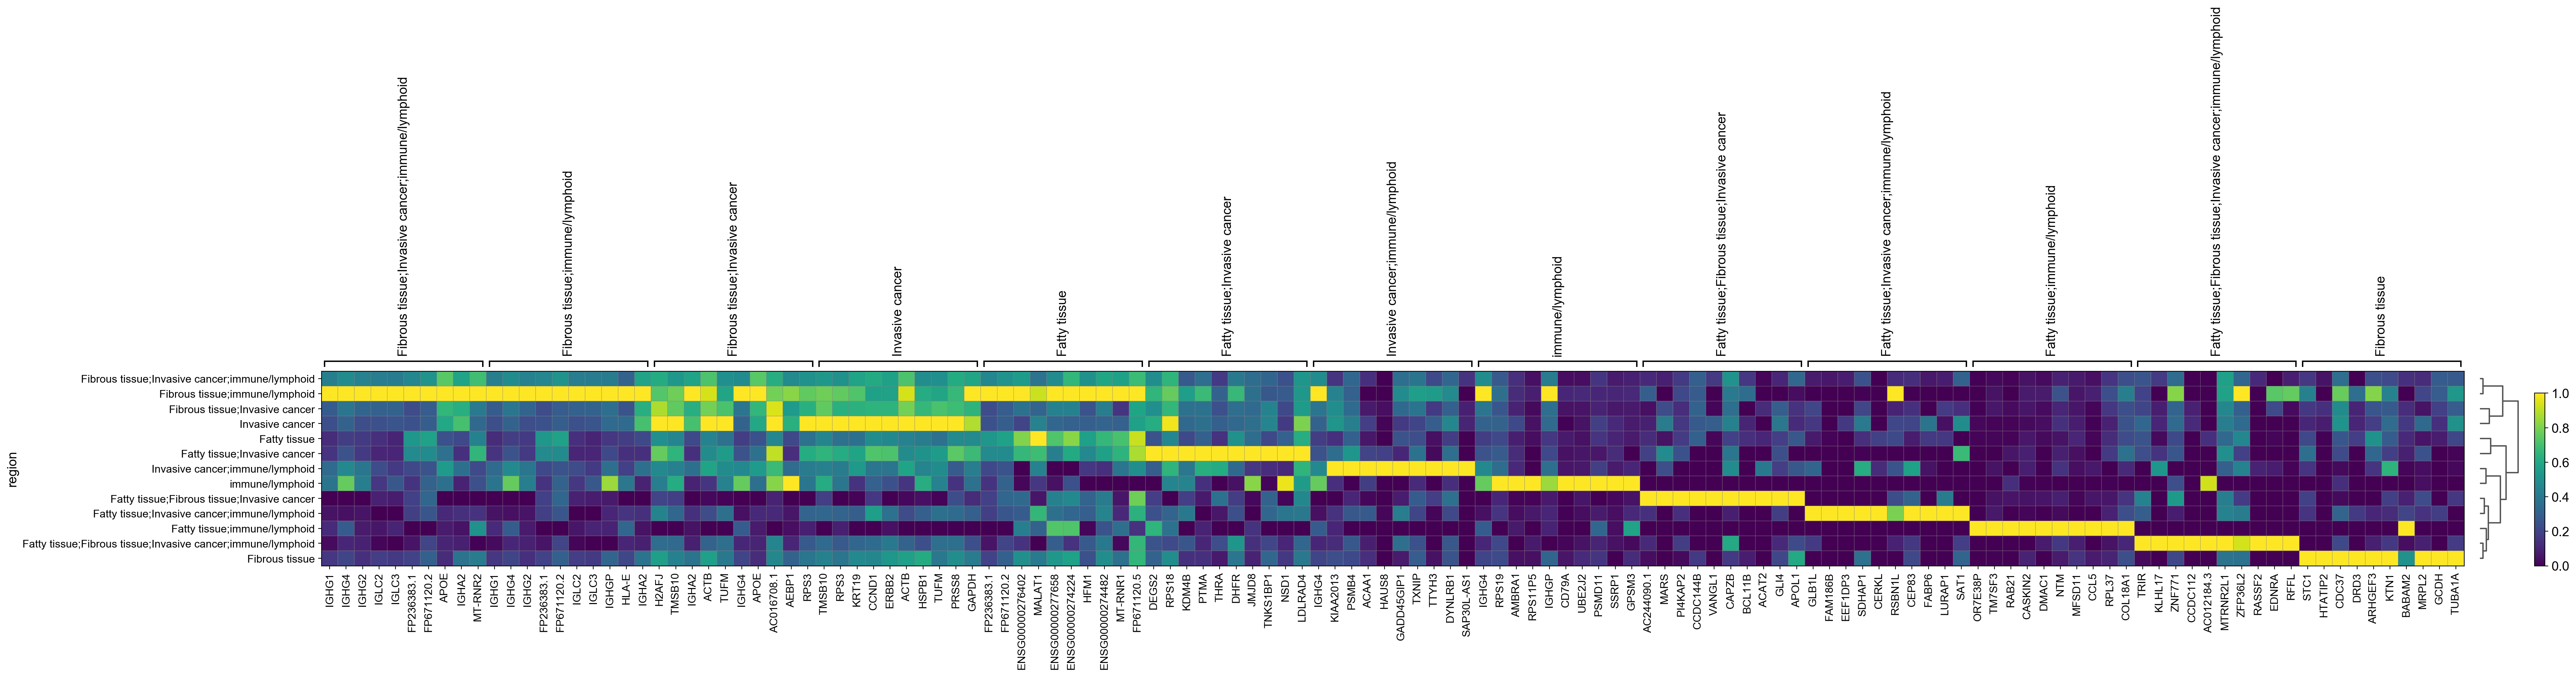

In [18]:
sc.pl.rank_genes_groups_matrixplot(adata_smooth_overall, standard_scale='var')

In [7]:
genes = pd.DataFrame(adata_smooth_overall.uns['rank_genes_groups']['names'])[:10].values.T.flatten()
xdf_mean = pd.DataFrame(adata_smooth_overall[:, genes].X, columns=genes).groupby(adata_smooth_overall.obs.region.values).mean()

xdf_mean -= xdf_mean.min(0)
xdf_mean = (xdf_mean / xdf_mean.max(0)).fillna(0)

xdf_mean.to_csv('results/bc_region_all_mean.csv')

In [108]:
df = tidy_up_scanpy_de_all(adata_smooth_overall, 'region')
df = df[(df.log2foldchanges > 1.5) & (df.pvalsadj < 0.1)]
df = df.sort_values('pvalsadj').reset_index(drop=True)
df.to_excel('results/bc-region-all-DE.xls')

... storing 'region' as categorical


['Fatty tissue', 'Fibrous tissue', 'Invasive cancer', 'immune/lymphoid']
[(0, 9), (10, 19), (20, 29), (30, 39)]
         Falling back to preprocessing with `sc.pp.pca` and default params.


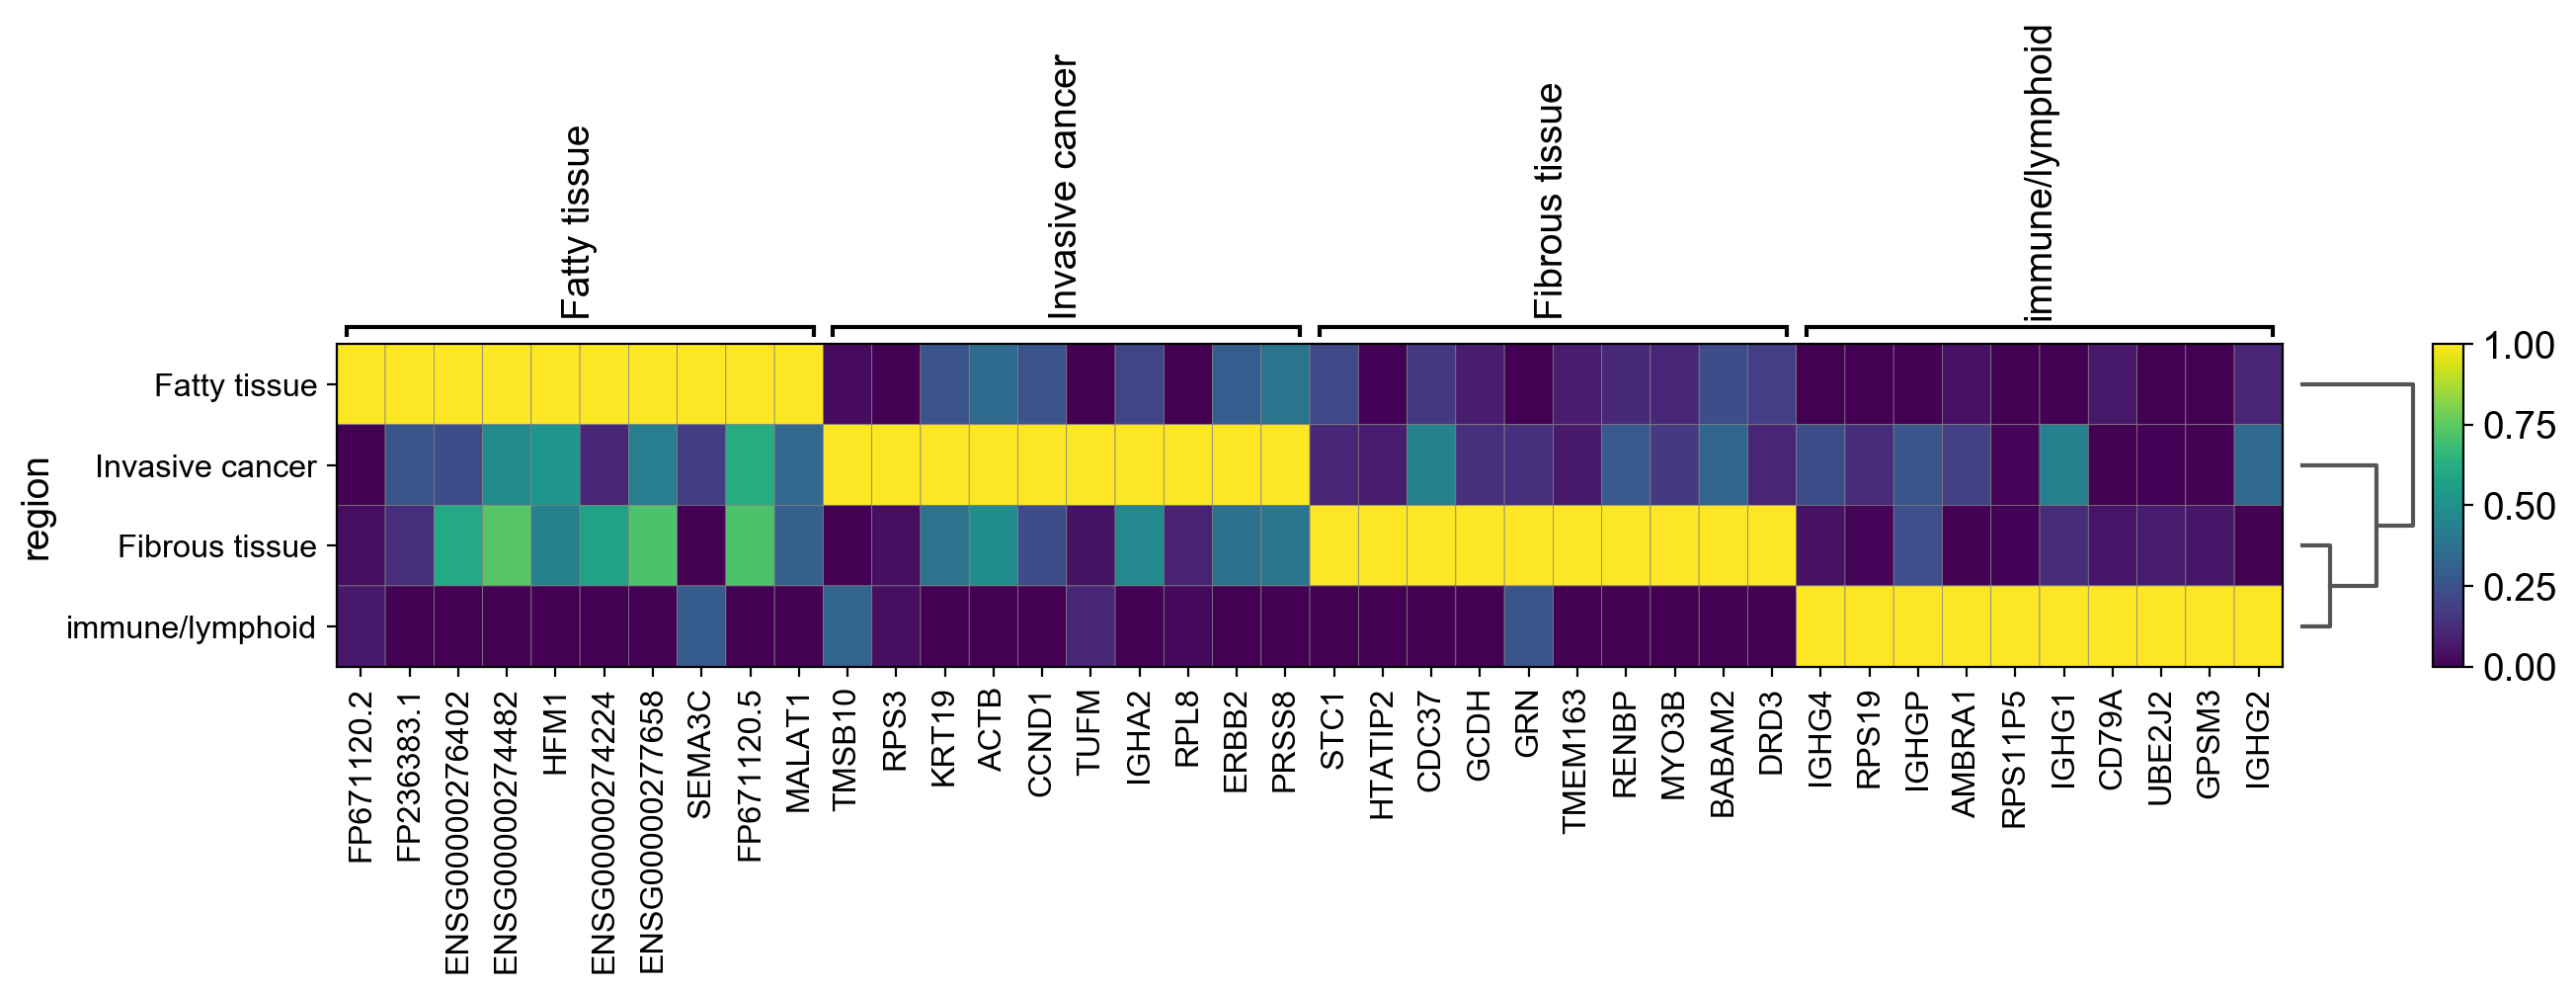

In [15]:
sc.pl.rank_genes_groups_matrixplot(adata_smooth_overall, standard_scale='var', n_genes=10)